**Project 1: Chest X-Ray image classification**

Alireza Amiri

# **Part 1 - Image Classification**

As the first part of the project, you should use your skills in image classification to solve this problem. You should
train your image classifier on the dataset. All the design parameters including type of the network, architecture, train
parameters, evaluation metrics, batch size, optimizer, the input resolution, etc. are arbitrarily and should be chosen
based on your knowledge, so be careful about your design. The minimum requirement of this part is:

**(a)** Training a MLP network with optimized parameters (layers, neurons, . . . )

**(b)** Training a CNN network with optimized parameters (layers, kernel size, . . . )

**(c)** Train at least 2 networks with state-of-the-art architectures (VGG16, VGG19, ResNet50, Inceptionv3, MobileNetv2, Xception, . . . ) as the feature extractors. Freeze all the layers in the networks and train your own
classifier on top of them.

**(d)** Train the networks from (c) again but unfreeze last 2 layers.

**(e)** Train the networks from (c) again but unfreeze last 6 layers.

**(f)** Train the best performing network from sections (a)–(e) again, with and without data augmentation.

## **Data preparation**

### **Downloading the dataset and unzipping it**

---



In [2]:

#!gdown 15KhnKTU89tZEy3CYbN-JFdhViiyiJQDS
!unzip chest-xray-pneumonia.zip -d chest-xray-pneumonia
y


Downloading...
From (original): https://drive.google.com/uc?id=15KhnKTU89tZEy3CYbN-JFdhViiyiJQDS
From (redirected): https://drive.google.com/uc?id=15KhnKTU89tZEy3CYbN-JFdhViiyiJQDS&confirm=t&uuid=919d5daf-2755-4f95-a841-07ddf452a4ce
To: /content/chest-xray-pneumonia.zip
100% 1.22G/1.22G [00:14<00:00, 81.9MB/s]
Archive:  chest-xray-pneumonia.zip
replace chest-xray-pneumonia/content/chest-xray-pneumonia/test/NORMAL/NORMAL2-IM-0206-0001.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

### **Organizing the files and folders to match the requirements of the project.**

---



according to downloaded dataset and the description of homework, we can see that images are categorised in Train,Test and Validation folders.
inside each, there are 2 folders named Normal and Pneumonia.

The point to consider is that our target in this project is to classify images into 3 classes as below:


1.   Normal
2.   Pneumonia-bacteria
3.   Pneumonia-virus

We can see that the separation of Normal and Pneumonia is already done and they are seperated in different folders, but to consider the type of dise, which is bacteria and virus, we must run another process.

In this case, we can see the name of diseases type is written in each image's file name. so in order to seperate them, we must search for words *bacteria* and *virus* in each file name, and then create a new folder with a new architecture to includ these 3 classes.

This is done using the code below:

First, downloaded files directories are saved into 3 variables, and then we create new directories and folders with the same structure but with 3 classes instead of 2.

Then, the files from original folder are copied to the recently created folders. The consideration to make here is that all Normal images are directly copied to corresponding folder, but the images of Pneumonia class are first seperated based on their disease type and then moved to the corresponding folder.


In [10]:
import os
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16
from sklearn.metrics import classification_report, confusion_matrix

# Define original directories
original_train_dir = 'C://Users//lenovo//Documents//AI and ES//Project 1//content//chest-xray-pneumonia//train'
original_val_dir = 'C://Users//lenovo//Documents//AI and ES//Project 1//content//chest-xray-pneumonia//val'
original_test_dir = 'C://Users//lenovo//Documents//AI and ES//Project 1//content//chest-xray-pneumonia//test'

# Define new directories
base_dir = 'C:\\Users\\lenovo\Documents\\AI and ES\\Project 1\\content\\chest-xray-pneumonia-preprocessed'
new_train_dir = os.path.join(base_dir, 'train')
new_val_dir = os.path.join(base_dir, 'val')
new_test_dir = os.path.join(base_dir, 'test')

# Create new directory structure
for dir_path in [new_train_dir, new_val_dir, new_test_dir]:
    os.makedirs(os.path.join(dir_path, 'healthy'), exist_ok=True)
    os.makedirs(os.path.join(dir_path, 'pneumonia-bacteria'), exist_ok=True)
    os.makedirs(os.path.join(dir_path, 'pneumonia-virus'), exist_ok=True)

def move_files(original_dir, new_dir):
    for category in ['NORMAL', 'PNEUMONIA']:
        category_path = os.path.join(original_dir, category)
        if category == 'NORMAL':
            for filename in os.listdir(category_path):
                src = os.path.join(category_path, filename)
                dst = os.path.join(new_dir, 'healthy', filename)
                shutil.copy(src, dst)
        else:
            for filename in os.listdir(category_path):
                if 'bacteria' in filename:
                    dst_category = 'pneumonia-bacteria'
                elif 'virus' in filename:
                    dst_category = 'pneumonia-virus'
                else:
                    continue
                src = os.path.join(category_path, filename)
                dst = os.path.join(new_dir, dst_category, filename)
                shutil.copy(src, dst)

# Move files to the new directory structure
move_files(original_train_dir, new_train_dir)
move_files(original_val_dir, new_val_dir)
move_files(original_test_dir, new_test_dir)


### **Data Analysis**

---



Having the files organised properly, we can get some analytical information of the given dataset.

This is done by counting the number of images in each folder and also counting the number of each label present in each folder. at the end, bar charts are plotted.

C:\Users\lenovo\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\lenovo\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\lenovo\anaconda3\lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
C:\Users\lenovo\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categoric

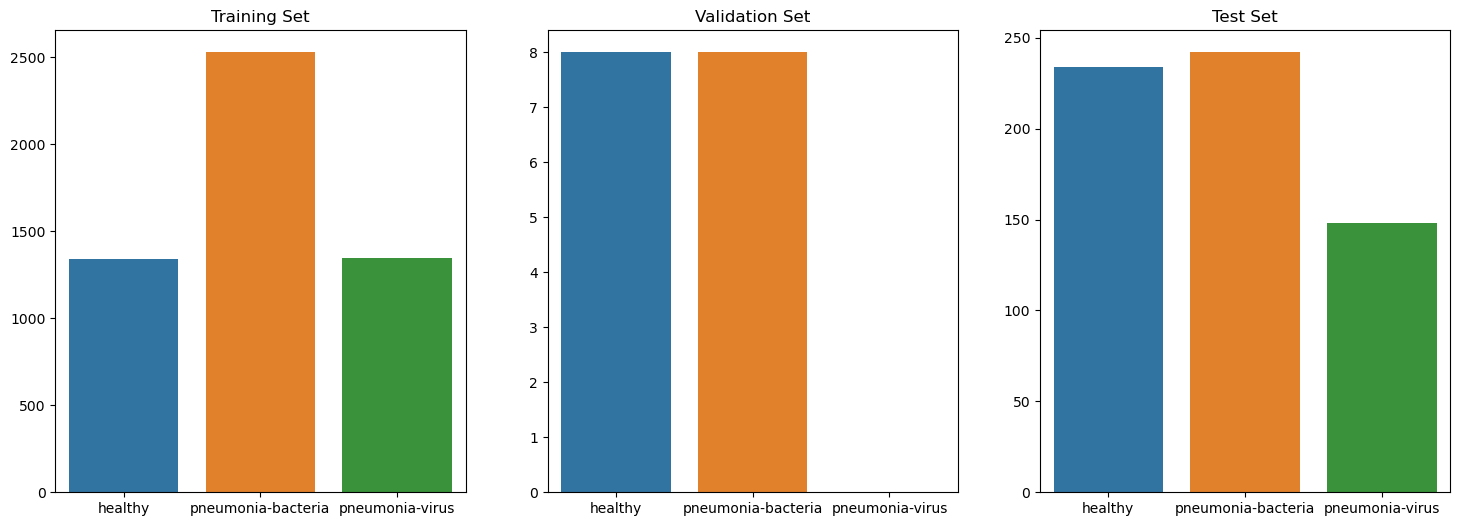

In [11]:
# Count the number of images in each class
def count_images(directory):
    count_dict = {}
    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        count_dict[subdir] = len(os.listdir(subdir_path))
    return count_dict

train_counts = count_images(new_train_dir)
val_counts = count_images(new_val_dir)
test_counts = count_images(new_test_dir)

# Plot the distribution of the dataset
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
sns.barplot(x=list(train_counts.keys()), y=list(train_counts.values()), ax=axs[0]).set_title('Training Set')
sns.barplot(x=list(val_counts.keys()), y=list(val_counts.values()), ax=axs[1]).set_title('Validation Set')
sns.barplot(x=list(test_counts.keys()), y=list(test_counts.values()), ax=axs[2]).set_title('Test Set')
plt.show()


### **Preprocessing**

---



Next, we apply the preprocessings required on the resulting dataset.

The process includes data augmentation in which crops all the images to an specific size and then add rotation and zoom to images to enable the model to learn patterns in data. also, the value of pixels are normalized by dividing their values by 255.

At the end, sample files are presented.

Found 4173 images belonging to 3 classes.
Found 1043 images belonging to 3 classes.
Found 624 images belonging to 3 classes.


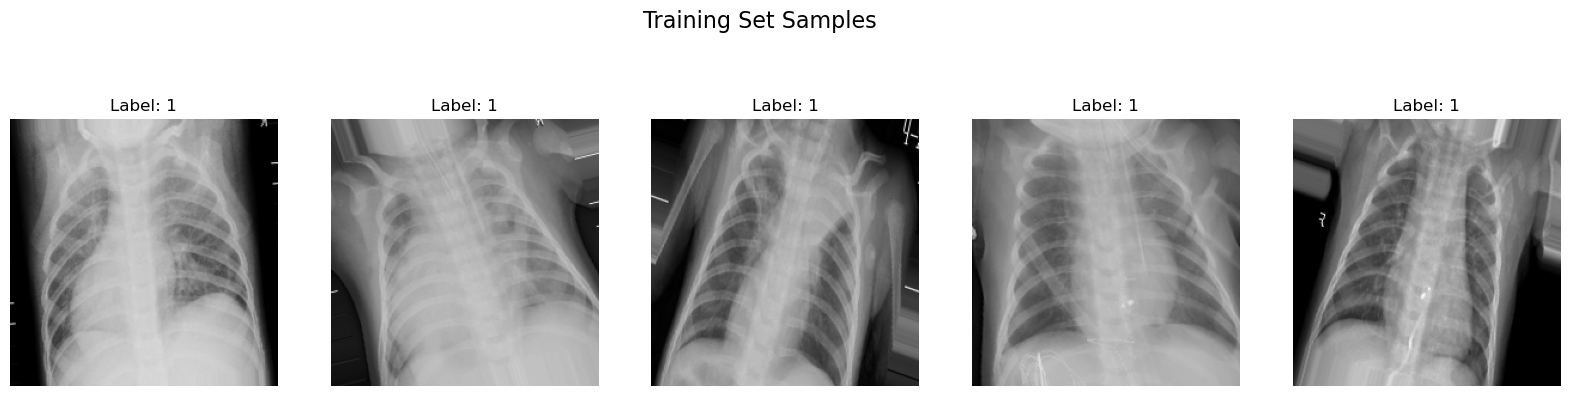

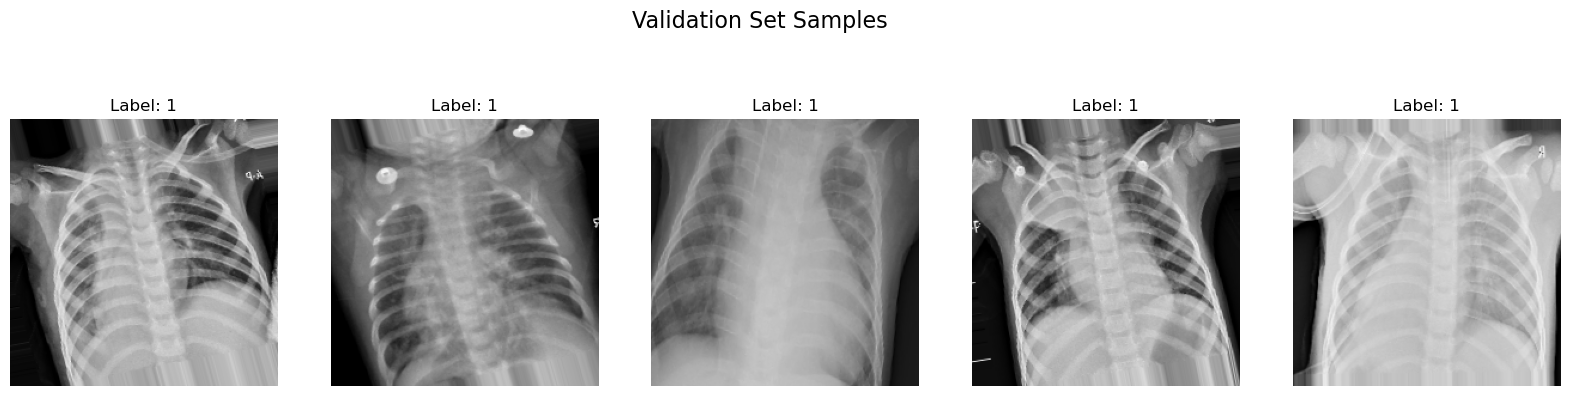

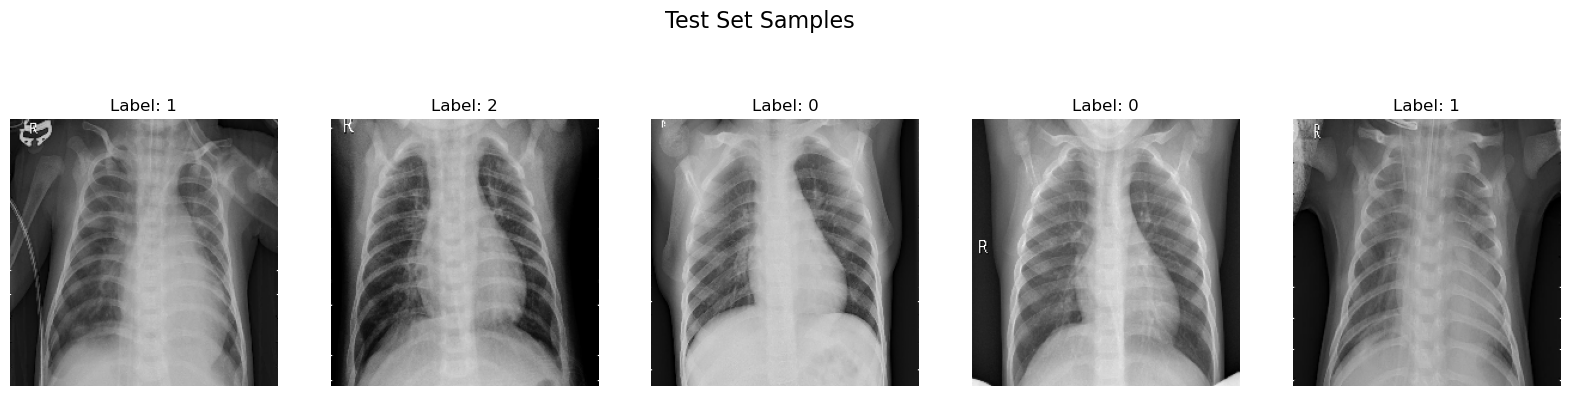

<function IPython.core.display_functions.display(*objs, include=None, exclude=None, metadata=None, transient=None, display_id=None, raw=False, clear=False, **kwargs)>

In [12]:
# Display some sample images with their labels
def display_sample_images(generator, title):
    x, y = next(generator)
    fig, axes = plt.subplots(1, 5, figsize=(20, 5))
    fig.suptitle(title, fontsize=16)
    for i in range(5):
        axes[i].imshow(x[i])
        axes[i].set_title(f"Label: {np.argmax(y[i])}")
        axes[i].axis('off')
    plt.show()

# Define new paths
train_dir = new_train_dir
val_dir = new_val_dir
test_dir = new_test_dir

# Define parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    #rotation_range=20,
    #zoom_range=0.2,
    #horizontal_flip=True,
    validation_split=0.2
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_dir,  # Using train_dir with validation_split
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Display sample images
# Display sample images
display_sample_images(train_generator, 'Training Set Samples')
display_sample_images(val_generator, 'Validation Set Samples')
display_sample_images(test_generator, 'Test Set Samples')

display

### **Part (a): MLP model training:**

---



The first step before training an MLP model is importing necessary packages.

Next, we must define a class for plotting required charts (such as accuracy and loss) for evaluating each of the trained models

**MLP architecture:**
A 4 layer MLP is first designed with input shape of (224,224,1), 2 Dense layers with 128 neuros, one layer with 64 neurons and a final layer with 3 neurons acting as output layer.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16
from sklearn.metrics import classification_report, confusion_matrix



# Plot training history
def plot_training_history(history, title):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    axs[0].plot(history.history['accuracy'], label='train accuracy')
    axs[0].plot(history.history['val_accuracy'], label='val accuracy')
    axs[0].set_title(f'{title} - Accuracy')
    axs[0].legend()
    axs[1].plot(history.history['loss'], label='train loss')
    axs[1].plot(history.history['val_loss'], label='val loss')
    axs[1].set_title(f'{title} - Loss')
    axs[1].legend()
    plt.show()

Epoch 1/25
131/131 [==============================] - 70s 532ms/step - loss: 6.3870 - accuracy: 0.4529 - val_loss: 1.5353 - val_accuracy: 0.3461
Epoch 2/25
131/131 [==============================] - 68s 517ms/step - loss: 0.9747 - accuracy: 0.5826 - val_loss: 0.8229 - val_accuracy: 0.6433
Epoch 3/25
131/131 [==============================] - 67s 514ms/step - loss: 1.0579 - accuracy: 0.5912 - val_loss: 0.9229 - val_accuracy: 0.6165
Epoch 4/25
131/131 [==============================] - 68s 517ms/step - loss: 0.9030 - accuracy: 0.6137 - val_loss: 0.8913 - val_accuracy: 0.5714
Epoch 5/25
131/131 [==============================] - 68s 518ms/step - loss: 0.8036 - accuracy: 0.6362 - val_loss: 0.8222 - val_accuracy: 0.6759
Epoch 6/25
131/131 [==============================] - 68s 522ms/step - loss: 0.8693 - accuracy: 0.6293 - val_loss: 2.8795 - val_accuracy: 0.2752
Epoch 7/25
131/131 [==============================] - 67s 514ms/step - loss: 0.8517 - accuracy: 0.6326 - val_loss: 0.7606 - val_ac

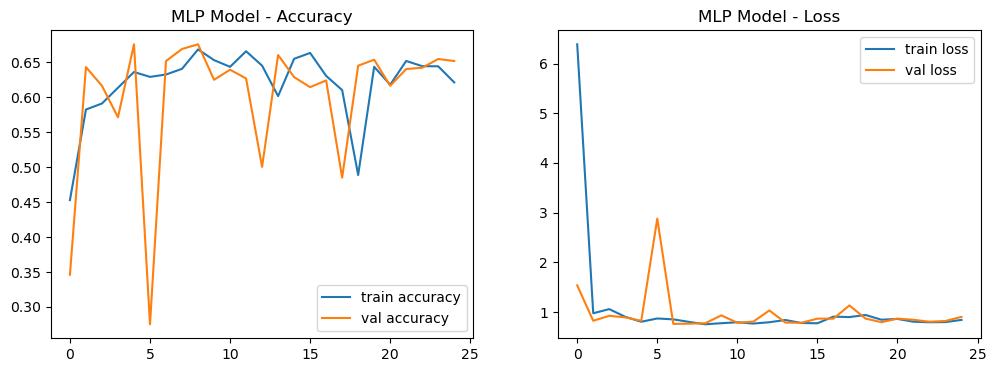

In [16]:

# MLP Model
mlp_model = Sequential([
    Flatten(input_shape=(224, 224, 3)),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')  # Ensure this matches the number of classes
])

mlp_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

mlp_history = mlp_model.fit(
    train_generator,
    epochs=25,
    validation_data=val_generator
)

plot_training_history(mlp_history, 'MLP Model')



### **Part (b): CNN model training:**

---


In this part, a CNN model is trained with 4 layers of Convolution and Max pooling layers. At the end, the output of these layers are flattened and using another dense layer with only 3 neurons and a softmax activation function, the labels are defined.

In [13]:
# CNN Model
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(3, activation='softmax')  # Ensure this matches the number of classes
])

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

cnn_history = cnn_model.fit(
    train_generator,
    epochs=25,
    validation_data=val_generator
)

plot_training_history(cnn_history, 'CNN Model')



Epoch 1/25
131/131 [==============================] - 137s 1s/step - loss: 0.8778 - accuracy: 0.5924 - val_loss: 0.7594 - val_accuracy: 0.6500
Epoch 2/25
131/131 [==============================] - 100s 762ms/step - loss: 0.6745 - accuracy: 0.7177 - val_loss: 0.6858 - val_accuracy: 0.7124
Epoch 3/25
131/131 [==============================] - 102s 780ms/step - loss: 0.6245 - accuracy: 0.7335 - val_loss: 0.6481 - val_accuracy: 0.7133
Epoch 4/25
131/131 [==============================] - 98s 752ms/step - loss: 0.5995 - accuracy: 0.7434 - val_loss: 0.6779 - val_accuracy: 0.7037
Epoch 5/25
131/131 [==============================] - 106s 811ms/step - loss: 0.5947 - accuracy: 0.7441 - val_loss: 0.6390 - val_accuracy: 0.7210
Epoch 6/25
131/131 [==============================] - 99s 757ms/step - loss: 0.5637 - accuracy: 0.7695 - val_loss: 0.6026 - val_accuracy: 0.7354
Epoch 7/25
131/131 [==============================] - 100s 760ms/step - loss: 0.5535 - accuracy: 0.7659 - val_loss: 0.6009 - val_

NameError: name 'plot_training_history' is not defined

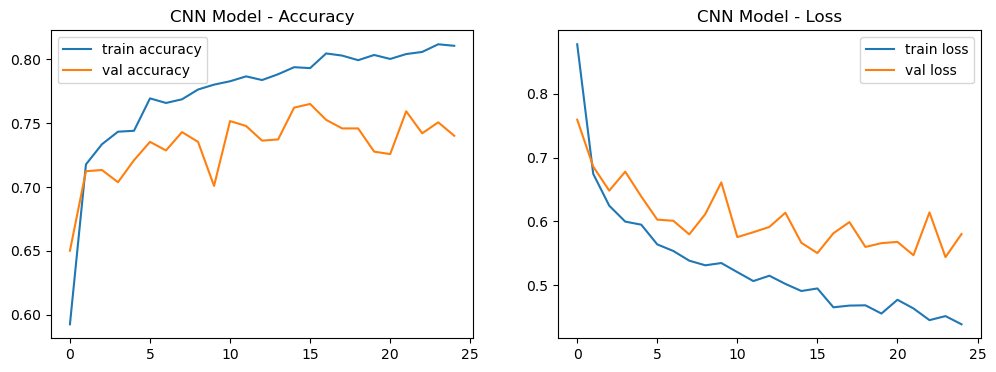

In [15]:
# Plot training history
def plot_training_history(history, title):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    axs[0].plot(history.history['accuracy'], label='train accuracy')
    axs[0].plot(history.history['val_accuracy'], label='val accuracy')
    axs[0].set_title(f'{title} - Accuracy')
    axs[0].legend()
    axs[1].plot(history.history['loss'], label='train loss')
    axs[1].plot(history.history['val_loss'], label='val loss')
    axs[1].set_title(f'{title} - Loss')
    axs[1].legend()
    plt.show()
    
plot_training_history(cnn_history, 'CNN Model')

### **Part (c): State-Of-The-Art model training:**

---


For subsequent sections of this project, we need to utilize pretrained models and add the desired classifiers on top of them.

To do so, we first define a function which have base model and number of trainable layers as input. then the desired classifier which consists of a GlobalAveragePooling2D, a dense layer with 128 neurons and an output layer is added to the end of the model.

Having this function in hand, we can easily change the SOTA model and number of trainable layers and perform the actions asked in each part of the project.


In [17]:

def create_pretrained_model(base_model, trainable_layers=0):
    base_model.trainable = False
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dense(3, activation='softmax')  # Ensure this matches the number of classes
    ])

    if trainable_layers > 0:
        for layer in base_model.layers[-trainable_layers:]:
            layer.trainable = True

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


**VGG16 model (all layers freezed)**

---


58889256/58889256 [==============================] - 547s 9us/step
Epoch 1/10
131/131 [==============================] - 285s 2s/step - loss: 0.8026 - accuracy: 0.6506 - val_loss: 0.7440 - val_accuracy: 0.6654
Epoch 2/10
131/131 [==============================] - 287s 2s/step - loss: 0.6443 - accuracy: 0.7259 - val_loss: 0.6658 - val_accuracy: 0.7143
Epoch 3/10
131/131 [==============================] - 286s 2s/step - loss: 0.5977 - accuracy: 0.7455 - val_loss: 0.6413 - val_accuracy: 0.7220
Epoch 4/10
131/131 [==============================] - 286s 2s/step - loss: 0.5868 - accuracy: 0.7520 - val_loss: 0.6429 - val_accuracy: 0.7162
Epoch 5/10
131/131 [==============================] - 285s 2s/step - loss: 0.5814 - accuracy: 0.7561 - val_loss: 0.6352 - val_accuracy: 0.7200
Epoch 6/10
131/131 [==============================] - 286s 2s/step - loss: 0.5643 - accuracy: 0.7630 - val_loss: 0.6130 - val_accuracy: 0.7363
Epoch 7/10
131/131 [==============================] - 286s 2s/step - loss: 

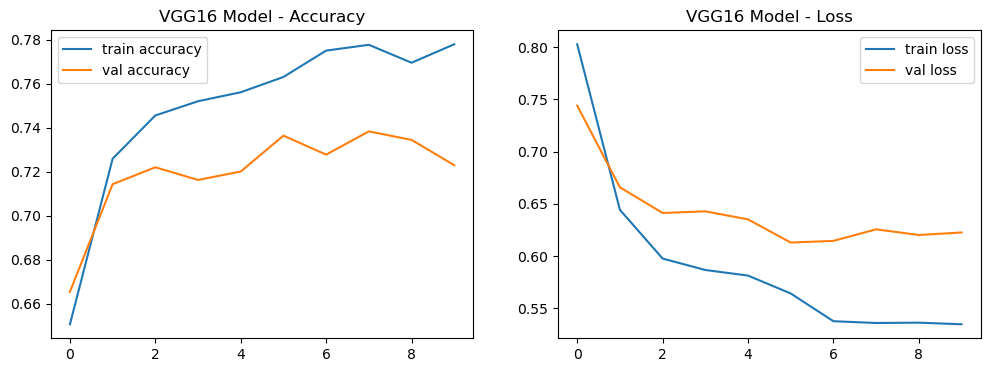

In [18]:
# VGG16 as feature extractor
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg16_model = create_pretrained_model(vgg16_base)

vgg16_history = vgg16_model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)

plot_training_history(vgg16_history, 'VGG16 Model')



**ResNet50 model (all layers freezed)**

---


In [19]:
resnet50_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
resnet50_model = create_pretrained_model(resnet50_base)

resnet50_history = resnet50_model.fit(
    train_generator,
    epochs=25,
    validation_data=val_generator
)

plot_training_history(resnet50_history, 'ResNet50 Model')

NameError: name 'ResNet50' is not defined

### **Part (d): freezing last 2 layers of SOTA models:**

---


**VGG16 model (last 2 layers unfreezed)**

---


In [ ]:
# Unfreeze last 2 layers and train
vgg16_model_2 = create_pretrained_model(vgg16_base, trainable_layers=2)

vgg16_history_2 = vgg16_model_2.fit(
    train_generator,
    epochs=25,
    validation_data=val_generator
)

plot_training_history(vgg16_history_2, 'VGG16 Model (Last 2 Layers Unfrozen)')



**ResNet50 model (last 2 layers unfreezed)**

---


In [ ]:
resnet50_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
resnet50_model_2 = create_pretrained_model(resnet50_base,trainable_layers=2)

resnet50_history_2 = resnet50_model_2.fit(
    train_generator,
    epochs=25,
    validation_data=val_generator
)

plot_training_history(resnet50_history_2, 'ResNet50 Model (Last 2 Layers Unfrozen)')

### **Part (e): freezing last 6 layers of SOTA models:**

---

**VGG16 model (last 6 layers unfreezed)**

---

In [ ]:
# Unfreeze last 6 layers and train
vgg16_model_6 = create_pretrained_model(vgg16_base, trainable_layers=6)

vgg16_history_6 = vgg16_model_6.fit(
    train_generator,
    epochs=25,
    validation_data=val_generator
)

plot_training_history(vgg16_history_6, 'VGG16 Model (Last 6 Layers Unfrozen)')



**ResNet50 model (last 6 layers unfreezed)**

---

In [ ]:
resnet50_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
resnet50_model_6 = create_pretrained_model(resnet50_base,trainable_layers=6)

resnet50_history = resnet50_model_6.fit(
    train_generator,
    epochs=25,
    validation_data=val_generator
)

plot_training_history(resnet50_history_6, 'ResNet50 Model (Last 6 Layers Unfrozen)')

**Evaluation of models**

---

To evaluate and compare models, we define a function with the desired measures such as classification reports, confusion matrixes, precision and F1-score.
Then we can apply this function to each of the models.

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

def evaluate_model(model, test_generator):
    test_loss, test_acc = model.evaluate(test_generator)
    y_pred = model.predict(test_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = test_generator.classes
    class_report = classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys(), output_dict=True)
    conf_matrix = confusion_matrix(y_true, y_pred_classes)

    # Extract precision and F1-score
    precision = class_report['weighted avg']['precision']
    f1_score = class_report['weighted avg']['f1-score']

    return test_loss, test_acc, class_report, conf_matrix, precision, f1_score


Having the evaluate_model function, we apply it on each of the trained models

In [ ]:
# Evaluate models
results = []

mlp_test_loss, mlp_test_acc, mlp_class_report, mlp_conf_matrix, mlp_precision, mlp_f1_score = evaluate_model(mlp_model, test_generator)
results.append(['MLP', mlp_test_loss, mlp_test_acc, mlp_precision, mlp_f1_score])

cnn_test_loss, cnn_test_acc, cnn_class_report, cnn_conf_matrix, cnn_precision, cnn_f1_score = evaluate_model(cnn_model, test_generator)
results.append(['CNN', cnn_test_loss, cnn_test_acc, cnn_precision, cnn_f1_score])

vgg16_test_loss, vgg16_test_acc, vgg16_class_report, vgg16_conf_matrix, vgg16_precision, vgg16_f1_score = evaluate_model(vgg16_model, test_generator)
results.append(['VGG16', vgg16_test_loss, vgg16_test_acc, vgg16_precision, vgg16_f1_score])

vgg16_2_test_loss, vgg16_2_test_acc, vgg16_2_class_report, vgg16_2_conf_matrix, vgg16_2_precision, vgg16_2_f1_score = evaluate_model(vgg16_model_2, test_generator)
results.append(['VGG16 (Last 2 Layers Unfrozen)', vgg16_2_test_loss, vgg16_2_test_acc, vgg16_2_precision, vgg16_2_f1_score])

vgg16_6_test_loss, vgg16_6_test_acc, vgg16_6_class_report, vgg16_6_conf_matrix, vgg16_6_precision, vgg16_6_f1_score = evaluate_model(vgg16_model_6, test_generator)
results.append(['VGG16 (Last 6 Layers Unfrozen)', vgg16_6_test_loss, vgg16_6_test_acc, vgg16_6_precision, vgg16_6_f1_score])

resnet50_test_loss, resnet50_test_acc, resnet50_class_report, resnet50_conf_matrix, resnet50_precision, resnet50_f1_score = evaluate_model(resnet50_model, test_generator)
results.append(['ResNet50', resnet50_test_loss, resnet50_test_acc, resnet50_precision, resnet50_f1_score])

resnet50_2_test_loss, resnet50_2_test_acc, resnet50_2_class_report, resnet50_2_conf_matrix, resnet50_2_precision, resnet50_2_f1_score = evaluate_model(resnet50_model_2, test_generator)
results.append(['ResNet50 (Last 2 Layers Unfrozen)', resnet50_2_test_loss, resnet50_2_test_acc, resnet50_2_precision, resnet50_2_f1_score])

resnet50_6_test_loss, resnet50_6_test_acc, resnet50_6_class_report, resnet50_6_conf_matrix, resnet50_6_precision, resnet50_6_f1_score = evaluate_model(resnet50_model_6, test_generator)
results.append(['ResNet50 (Last 6 Layers Unfrozen)', resnet50_6_test_loss, resnet50_6_test_acc, resnet50_6_precision, resnet50_6_f1_score])

# Create a results DataFrame
results_df = pd.DataFrame(results, columns=['Model', 'Test Loss', 'Test Accuracy', 'Precision', 'F1 Score'])

# Display results in a table
print(results_df)

# Display classification report for the best model
best_model_report = pd.DataFrame(vgg16_6_class_report).transpose()
print(best_model_report)

# Function to plot the confusion matrix
def plot_confusion_matrix(conf_matrix, class_names, title):
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Plot confusion matrix for each model
class_names = list(test_generator.class_indices.keys())

plot_confusion_matrix(mlp_conf_matrix, class_names, 'Confusion Matrix for MLP')
plot_confusion_matrix(cnn_conf_matrix, class_names, 'Confusion Matrix for CNN')
plot_confusion_matrix(vgg16_conf_matrix, class_names, 'Confusion Matrix for VGG16')
plot_confusion_matrix(vgg16_2_conf_matrix, class_names, 'Confusion Matrix for VGG16 (Last 2 Layers Unfrozen)')
plot_confusion_matrix(vgg16_6_conf_matrix, class_names, 'Confusion Matrix for VGG16 (Last 6 Layers Unfrozen)')
plot_confusion_matrix(resnet50_conf_matrix, class_names, 'Confusion Matrix for ResNet50')
plot_confusion_matrix(resnet50_2_conf_matrix, class_names, 'Confusion Matrix for ResNet50 (Last 2 Layers Unfrozen)')
plot_confusion_matrix(resnet50_6_conf_matrix, class_names, 'Confusion Matrix for ResNet50 (Last 6 Layers Unfrozen)')


**Saving models**

---

In [ ]:
mlp_model.save('C://Users//lenovo//Documents//AI and ES//Project 1//content//mlp_model.h5')
cnn_model.save('C://Users//lenovo//Documents//AI and ES//Project 1//content//cnn_model.h5')
vgg16_model.save('C://Users//lenovo//Documents//AI and ES//Project 1//content//vgg16_model.h5')
vgg16_model_6.save('C://Users//lenovo//Documents//AI and ES//Project 1//content//vgg16_model_6.h5')
vgg16_model_2.save('C://Users//lenovo//Documents//AI and ES//Project 1//content//vgg16_model_2.h5')
resnet50_model_model.save('C://Users//lenovo//Documents//AI and ES//Project 1//content//resnet50_model_model.h5')
resnet50_model_model_6.save('C://Users//lenovo//Documents//AI and ES//Project 1//content//resnet50_model_model_6.h5')
resnet50_model_model_2.save('C://Users//lenovo//Documents//AI and ES//Project 1//content//resnet50_model_model_2.h5')

**Run best performing model with augmentation**

---

In [ ]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    #rotation_range=20,
    #zoom_range=0.2,
    #horizontal_flip=True,
    validation_split=0.2
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

In [ ]:
# CNN Model
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(3, activation='softmax')  # Ensure this matches the number of classes
])

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

cnn_history = cnn_model.fit(
    train_generator,
    epochs=25,
    validation_data=val_generator
)

plot_training_history(cnn_history, 'CNN Model')
